In [1]:
import jax
from jax import random
import jax.numpy as jnp
from meta_transformer import utils
import numpy as np
import matplotlib.pyplot as plt
import optax

import experiments.train_cifar10 as train

rng = random.PRNGKey(42)
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 2048
NUM_EPOCHS = 150

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data
train_images, train_labels, test_images, test_labels = utils.load_data("cifar10")
test_data = {"img": test_images, "label": test_labels}

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 814.03it/s]


Number of parameters: 4.873226 Million
train/acc: 0.22, train/loss: 2.056
train/acc: 0.242, train/loss: 1.987
train/acc: 0.251, train/loss: 1.997, val/acc: 0.262, val/loss: 1.959


KeyboardInterrupt: 

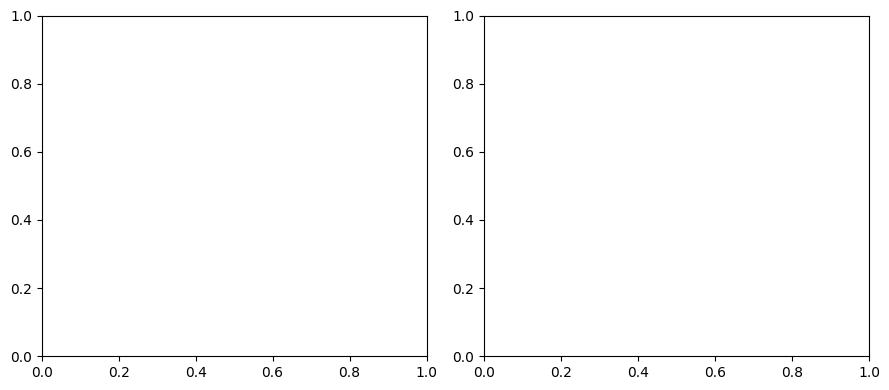

In [4]:
# Initialization
opt = optax.adamw(LEARNING_RATE, weight_decay=WEIGHT_DECAY)
updater = train.Updater(opt=opt)
logger = train.Logger(log_interval=50, disable_wandb=True)
rng, subkey = random.split(rng)
state = updater.init_params(subkey, {
    "img": train_images[:2], 
    "label": train_labels[:2]
    })

print("Number of parameters:", utils.count_params(state.params) / 1e6, "Million")
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.tight_layout()
lines = None

# Training loop
for epoch in range(NUM_EPOCHS):
    rng, subkey = random.split(rng)
    images, labels = train.shuffle_data(subkey, train_images, train_labels)
    batches = train.data_iterator(images, labels, batchsize=BATCH_SIZE, skip_last=True)

    for batch in batches:
        state, train_metrics = updater.update(state, batch)
        if state.step % 150 == 0:
            state, val_metrics = updater.compute_val_metrics(state, test_data)
            logger.log(state, train_metrics, val_metrics)
        else:
            logger.log(state, train_metrics)


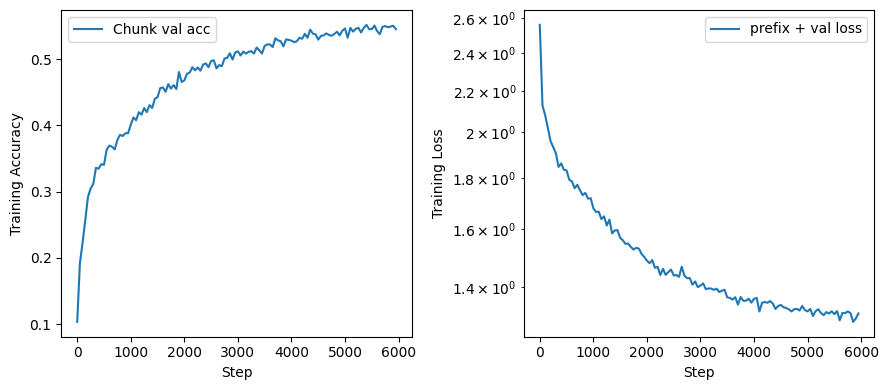

In [ ]:
# # TODO track metrics
# # Plot
# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# train.plot_metrics(metrics, axs)
# fig.tight_layout()
# plt.show()